## Задание 4.
Рассмотрим датасет по предсказанию года создания песни по числовым признакам.
Информацию о датасете можно найти здесь: 
- https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD#
- http://labrosa.ee.columbia.edu/millionsong
- https://en.wikipedia.org/wiki/Timbre

**Ссылка**: https://www.kaggle.com/t/c55b0b2354bd4ca5ac83fe5ed8b3eb92

Мы используем поднабор этого датасета. Пожалуйста, не используйте исходный датасет для читинга, за это получите 0 за ВООБЩЕ всю домашку. Это задание организовано с помощью соревнования на kaggle.
Попробуйте обучить нейронную сеть (используя линейные и другие слои, возможную нормализацию и активации). Можете использовать любые методы предобработки данных и фокусы, 
кроме ансамблирования и использования сторонних источников ДАННЫХ.
- Задание обязательно, базовое максимальное число баллов - 6. 
- Топ 25% получат +3 балла, топ 50 +2 балла, топ 75 +1 балл.
- Решение должно быть уникальным, необходимо предоставить код и описание решения. Если использованы внешние источники (туториалы, статьи и т.п.), необходимо предоставить ссылки.
- Обучите модель, используя ваш кастомный оптимизатор. Это даст еще 1 балл. Покажите, изменилось ли что-то.
- При решении задачи можно использовать любые встренные в torch модули (nn, optim, transforms, etc)
- Можно использовать numpy, sklearn, pandas ТОЛЬКО для предобработки и постобработки решения (сборки сабмишена). Для самой модели можно использовать только torch.
- При переобучении можно добавить dropout, batchnorm итд. 

# Предобработка
[Источник вдохновления](https://www.kaggle.com/code/raghav1810/release-year-prediction-on-msd-using-neural-nets)

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.model_selection import train_test_split        
from keras.utils import to_categorical                      # Стараемся привести количество
from sklearn.preprocessing import StandardScaler            # Делаем из данных нормально распределенные значения
from sklearn.decomposition import PCA                       # Метод главных компонент
from sklearn.model_selection import KFold                   # Кросс-валидация 
from sklearn.preprocessing import OneHotEncoder
plt.rcParams['figure.figsize'] = (18, 9)

df_x = pd.read_csv("../../datasets/YearPredictionMSD/train_x.csv", index_col="id") #, sep=","
df_y = pd.read_csv("../../datasets/YearPredictionMSD/train_y.csv", index_col="id")
df_exam = pd.read_csv("../../datasets/YearPredictionMSD/test_x.csv", index_col="id")
df = pd.merge(df_x, df_y, left_index=True, right_index=True)
df.info()
df_exam

<class 'pandas.core.frame.DataFrame'>
Index: 14000 entries, 133081 to 154731
Data columns (total 91 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   TimbreAvg1          14000 non-null  float64
 1   TimbreAvg2          14000 non-null  float64
 2   TimbreAvg3          14000 non-null  float64
 3   TimbreAvg4          14000 non-null  float64
 4   TimbreAvg5          14000 non-null  float64
 5   TimbreAvg6          14000 non-null  float64
 6   TimbreAvg7          14000 non-null  float64
 7   TimbreAvg8          14000 non-null  float64
 8   TimbreAvg9          14000 non-null  float64
 9   TimbreAvg10         14000 non-null  float64
 10  TimbreAvg11         14000 non-null  float64
 11  TimbreAvg12         14000 non-null  float64
 12  TimbreCovariance1   14000 non-null  float64
 13  TimbreCovariance2   14000 non-null  float64
 14  TimbreCovariance3   14000 non-null  float64
 15  TimbreCovariance4   14000 non-null  float64
 16  Tim

,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance69,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78
id,,,,,,,,,,,,,,,,,,,,,
3416,44.69970,7.96998,-15.16859,-15.88686,1.58073,-6.23497,-11.59792,-11.71405,4.32023,-8.56689,...,14.60884,16.70871,22.73881,12.92728,5.35942,33.01436,-54.54467,-2.53457,19.44396,8.74708
18991,50.75305,49.55872,30.33403,-13.05537,-34.51915,-21.38223,1.07836,-7.79340,15.95731,8.97746,...,-11.98495,56.64278,-58.77229,44.02523,-6.08207,127.27562,53.55449,-21.83976,-46.89782,-12.17533
11105,39.41930,-38.69590,-22.15177,-4.07812,-19.06480,-11.15927,14.99402,2.75120,2.32396,4.29177,...,11.35409,-90.24540,-123.84976,65.31781,8.30738,-148.93180,-162.58971,-6.31094,-116.44189,-7.85765
18902,46.67711,56.98689,-22.63047,-10.90758,4.69374,15.66760,-7.25281,13.54849,-1.37275,16.10065,...,-5.77311,-257.63385,32.63454,-117.37477,3.12995,61.86812,-246.54612,2.13762,27.88064,-13.57062
18958,40.14486,-20.88083,-7.30665,-1.21121,27.23754,-22.98837,-1.81173,-2.44144,0.06913,-3.55877,...,24.11829,262.05281,190.80106,224.96182,8.19406,-44.09140,-14.54322,-7.52484,-57.88128,0.91497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15293,39.44790,-64.93194,-0.83019,-5.25472,-8.50352,-9.31121,11.91198,-8.60336,-7.33098,-12.36373,...,137.83066,12.74870,-126.15534,-127.67152,7.90602,-5.43619,-218.05441,7.37368,61.07918,38.02987
7469,37.40456,-60.09514,19.40282,-2.78752,-22.26984,-3.78960,8.27761,-7.95887,3.72717,-2.46880,...,0.27233,-92.83365,19.10577,12.88895,5.68489,106.68987,-137.49480,-4.69688,9.18971,-11.15737
6586,43.53168,-122.30174,133.79228,29.69593,-72.74356,6.84467,-18.07552,0.23652,36.78711,4.75939,...,33.17404,-110.63114,75.84926,56.66991,-4.85303,-53.42711,143.93005,3.30087,-145.13657,9.38941


In [34]:
df.describe()
#df.to_csv("df_describe()", sep='\t', index = False)


,TimbreAvg1,TimbreAvg2,TimbreAvg3,TimbreAvg4,TimbreAvg5,TimbreAvg6,TimbreAvg7,TimbreAvg8,TimbreAvg9,TimbreAvg10,...,TimbreCovariance70,TimbreCovariance71,TimbreCovariance72,TimbreCovariance73,TimbreCovariance74,TimbreCovariance75,TimbreCovariance76,TimbreCovariance77,TimbreCovariance78,year
count,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,...,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000,14000.000000
mean,43.394558,1.540279,8.378243,1.315349,-6.476035,-9.503415,-2.243164,-1.660698,3.543946,1.892996,...,-72.008182,41.154440,37.892338,0.145765,17.576243,-28.502296,4.474666,17.717701,1.227647,1998.366714
std,6.074562,51.578894,35.742553,16.622971,22.823521,12.926176,14.700348,8.035388,10.629817,6.602191,...,171.932584,120.075095,96.748418,16.162963,115.706029,180.463987,13.592096,185.335542,22.018997,11.048088
min,7.199890,-302.031900,-257.525600,-120.723150,-142.160680,-60.198620,-100.602550,-51.443820,-75.539550,-31.344160,...,-1976.846950,-791.832320,-1237.931680,-227.608010,-2678.193680,-3059.906060,-100.618700,-5000.654060,-286.031200,1922.000000
25%,39.970260,-25.603507,-11.773080,-8.490435,-20.716735,-18.524397,-10.651808,-6.402985,-2.573275,-2.446435,...,-138.560657,-21.424297,-4.443660,-7.027105,-32.236598,-101.305695,-2.563620,-60.364940,-8.873683,1994.000000
50%,44.282770,8.800720,10.226865,-0.582025,-5.808040,-11.254920,-2.007255,-1.516640,3.658655,1.763500,...,-52.984525,29.218730,33.576620,0.770135,15.522650,-22.050410,3.021435,6.982460,-0.050725,2002.000000
75%,47.843418,36.610743,29.596557,9.035892,7.858092,-2.198952,6.725500,3.111740,9.935210,6.245860,...,14.405743,89.374030,78.710667,8.380725,66.429958,50.378898,9.912000,86.542642,9.664982,2006.000000
max,57.408630,240.617010,318.868960,143.841600,142.305480,68.300090,147.965260,52.331120,78.149440,36.596180,...,1081.951340,1473.745210,1458.580210,199.121500,1620.749740,1879.332480,352.359540,3165.372860,245.209770,2011.000000


In [35]:
#corr_matrix = df.corr()
#corr_matrix

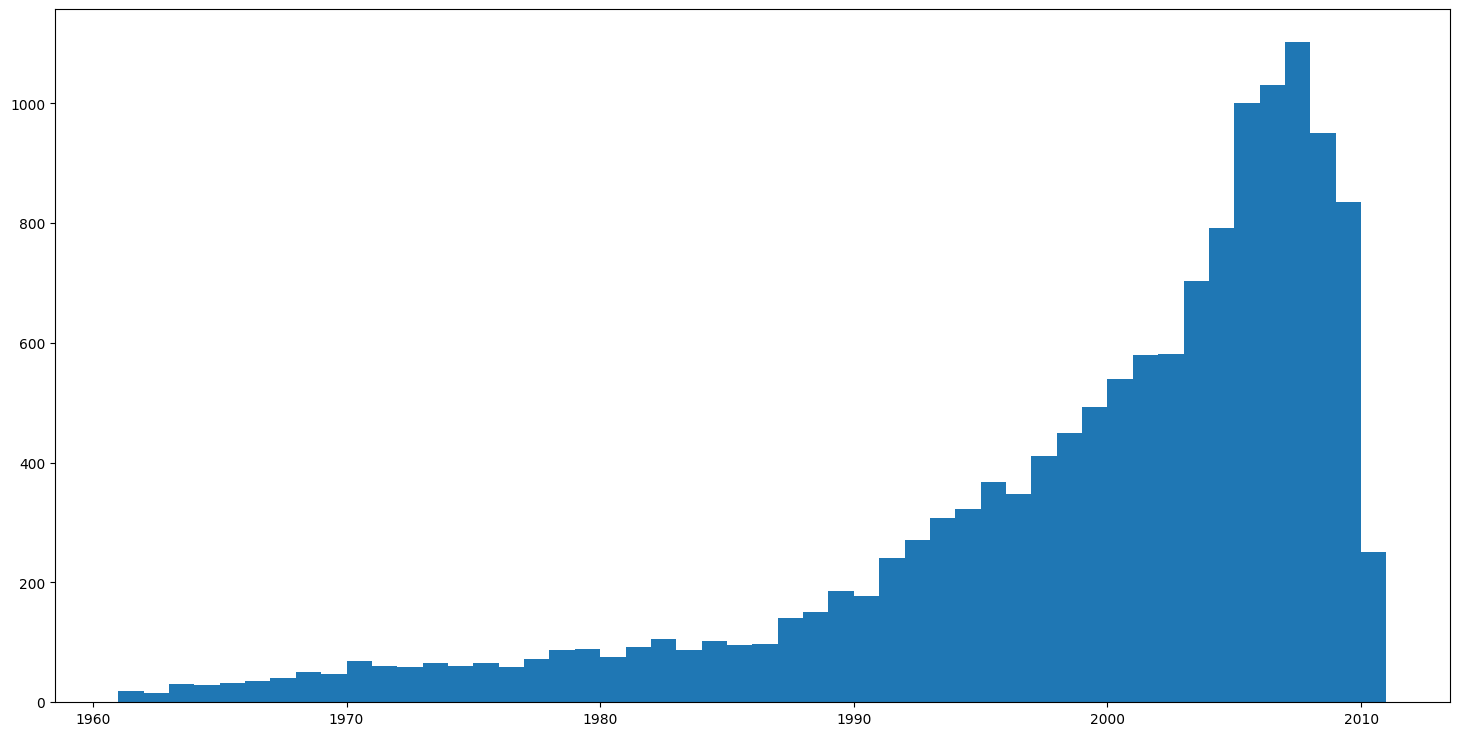

In [36]:
df = df[df["year"] > 1960]

a = plt.hist(df["year"], bins=50, )
#a[1]
#nsongs = {}
#for y in range(1960,2012):
#    nsongs[y] = len(df[df.year==y])
#yrs = range(1960,2011)
#values = [nsongs[y] for y in yrs]
#plt.bar(yrs, values, align='center')
#plt.xlabel("Year")
#plt.ylabel("Number of songs")
#b = a[0].sum() /  a[0]
#print((df["year"] > 1961))
# 13873

#yrs = range(1960,2011)
#values = [nsongs[y] for y in yrs]
#plt.bar(yrs, values, align='center')
#plt.xlabel("Year")
#plt.ylabel("Number of songs")

In [37]:
def plot_samples(data, labels_map, cols=3, rows=3):
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        if type(label) == torch.Tensor:
            plt.title(labels_map[label.item()])
        else:
            plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

In [38]:
len(df)

13873

In [39]:
#TimbreAvg1
df = df[df["TimbreAvg1"] > 15]

df = df[df["TimbreAvg2"] > -250][df["TimbreAvg2"] < 200]

df = df[df["TimbreAvg3"] > -200][df["TimbreAvg3"] < 200]

df = df[df["TimbreAvg4"] > -75][df["TimbreAvg4"] < 100]

df = df[df["TimbreAvg5"] > -100][df["TimbreAvg5"] < 100]

df = df[df["TimbreAvg6"] > -50][df["TimbreAvg6"] < 55]

df = df[df["TimbreAvg7"] > -80][df["TimbreAvg7"] < 70]

df = df[df["TimbreAvg8"] > -40][df["TimbreAvg8"] < 40]

df = df[df["TimbreAvg9"] > -60][df["TimbreAvg9"] < 60]

df = df[df["TimbreAvg10"] > -25][df["TimbreAvg10"] < 30]

df = df[df["TimbreAvg11"] > -20][df["TimbreAvg11"] < 20]

#13
df = df[df["TimbreCovariance14"] > -4000][df["TimbreCovariance14"] < 6000]
df = df[df["TimbreCovariance16"] > -1500][df["TimbreCovariance16"] < 1500]
df = df[df["TimbreCovariance17"] > -1250][df["TimbreCovariance17"] < 1000]
df = df[df["TimbreCovariance18"] < 1000]
df = df[df["TimbreCovariance19"] > -600][df["TimbreCovariance19"] < 600]
df = df[df["TimbreCovariance20"] < 600]
df = df[df["TimbreCovariance21"] > -400][df["TimbreCovariance21"] < 500]
df = df[df["TimbreCovariance22"] > -250][df["TimbreCovariance22"] < 400]
df = df[df["TimbreCovariance24"] > -500]
df = df[df["TimbreCovariance25"] < 3000]
df = df[df["TimbreCovariance28"] > -1500][df["TimbreCovariance28"] < 1500]
df = df[df["TimbreCovariance29"] > -750][df["TimbreCovariance29"] < 1000]
df = df[df["TimbreCovariance31"] > -750][df["TimbreCovariance31"] < 500]
df = df[df["TimbreCovariance32"] > -300][df["TimbreCovariance32"] < 200]
df = df[df["TimbreCovariance35"] > -3000][df["TimbreCovariance35"] < 3000]
df = df[df["TimbreCovariance36"] > -1100]

df = df[df["TimbreCovariance37"] > -1500][df["TimbreCovariance37"] < 1000]

df = df[df["TimbreCovariance38"] > -1000][df["TimbreCovariance38"] < 1000]

df = df[df["TimbreCovariance45"] > -2000][df["TimbreCovariance45"] < 2000]
df = df[df["TimbreCovariance46"] > -1500][df["TimbreCovariance46"] < 1800]

df = df[df["TimbreCovariance48"] > -1000][df["TimbreCovariance48"] < 1000]

df = df[df["TimbreCovariance49"] < 400]
df = df[df["TimbreCovariance55"] < 800]
df = df[df["TimbreCovariance58"] < 300]
df = df[df["TimbreCovariance60"] > -1750][df["TimbreCovariance60"] < 1750]
df = df[df["TimbreCovariance65"] > -2000][df["TimbreCovariance65"] < 2000]
df = df[df["TimbreCovariance78"] > -200]



df = df[df["TimbreCovariance1"] < 200]
df = df[df["TimbreCovariance2"] < 15000]
df = df[df["TimbreCovariance3"] < 10000]
df = df[df["TimbreCovariance4"] < 10000]
df = df[df["TimbreCovariance5"] < 5000]
df = df[df["TimbreCovariance6"] < 4500]
df = df[df["TimbreCovariance7"] < 2500]
df = df[df["TimbreCovariance8"] < 3000]

df = df[df["TimbreCovariance9"] < 2000]
df = df[df["TimbreCovariance10"] < 1400]
df = df[df["TimbreCovariance11"] < 1500]
df = df[df["TimbreCovariance12"] < 1500]


/tmp/ipykernel_30976/1059496205.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["TimbreAvg2"] > -250][df["TimbreAvg2"] < 200]
/tmp/ipykernel_30976/1059496205.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["TimbreAvg3"] > -200][df["TimbreAvg3"] < 200]
/tmp/ipykernel_30976/1059496205.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["TimbreAvg4"] > -75][df["TimbreAvg4"] < 100]
/tmp/ipykernel_30976/1059496205.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["TimbreAvg5"] > -100][df["TimbreAvg5"] < 100]
/tmp/ipykernel_30976/1059496205.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["TimbreAvg6"] > -50][df["TimbreAvg6"] < 55]
/tmp/ipykernel_30976/1059496205.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df["TimbreA

In [40]:
len(df)

13586

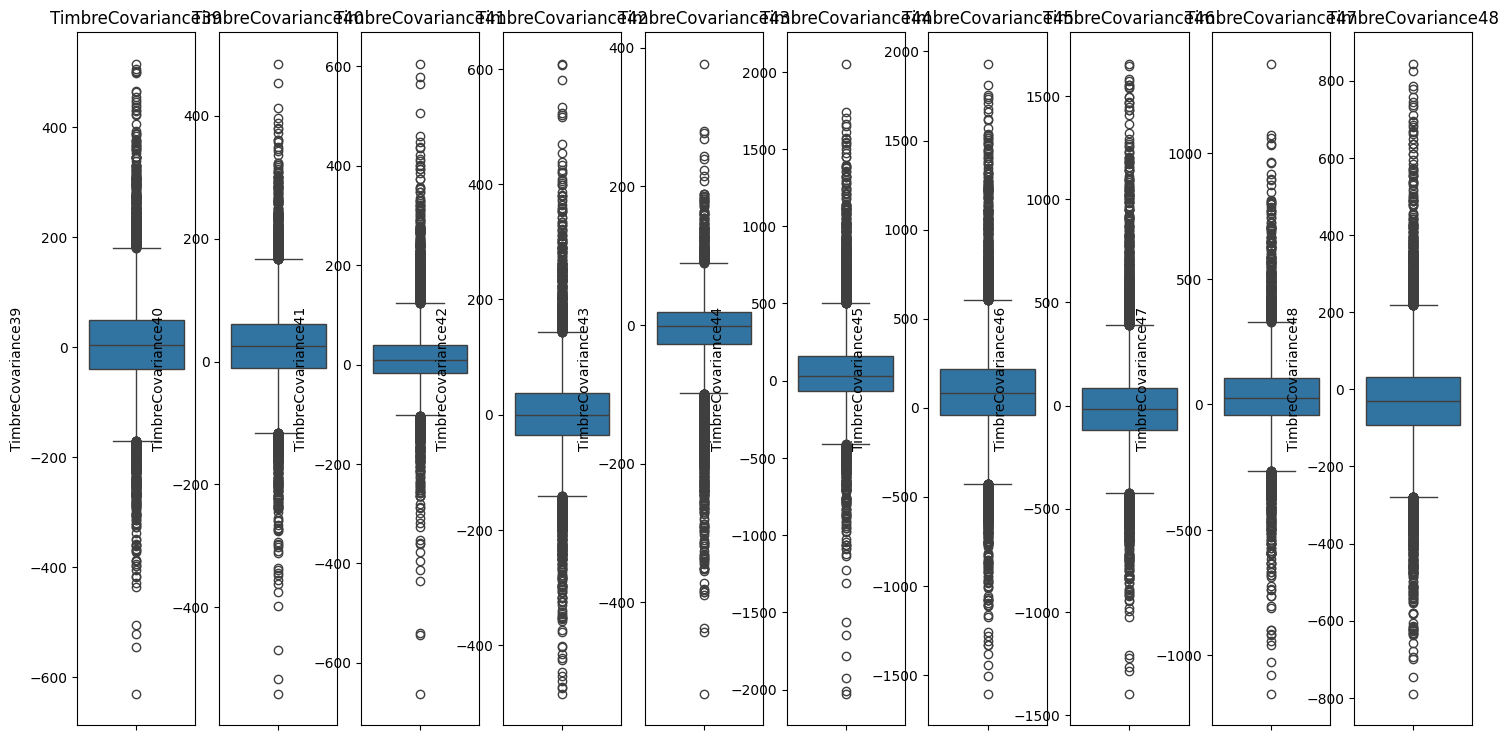

In [41]:
#sns.boxplot(data=df, y="TimbreAvg1")

width_num = 10
fig, axs = plt.subplots(ncols=width_num, )

index_num = 50

#print(figure)

for i in range(0, width_num):
    #sample_idx = torch.randint(len(data), size=(1,)).item()
    #img, label = data[sample_idx]
#    figure #.add_subplot(rows, cols, i)
#    print(df.columns[i])
    sns.boxplot(data=df, y=df.columns[index_num+i], ax=axs[i])
    axs[i].set_title(df.columns[index_num+i])


In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(["year"],axis=1), df["year"], test_size=0.2)

In [43]:
scaler = StandardScaler()
# Нормализация для обучаемого набора данных
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_norm, columns=X_train.columns)

# Нормализация для тестового набора данных
scaler.fit(X_test)
X_test_norm = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_norm, columns=X_test.columns)

Y_train = pd.DataFrame(Y_train, columns=["year"])
Y_test = pd.DataFrame(Y_test, columns=["year"])

### TO-DO Сделать метод главных компонент

In [44]:
#pca = PCA(.90)
#pca.fit(X_train)
#pca.n_components_


#X_train_proc = torch.tensor(pca.transform(X_train_std), dtype=torch.float)
#X_test_proc = torch.tensor(pca.transform(X_test_std), dtype=torch.float)

### TO-DO: Сделать промежутки для классов

In [45]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder(handle_unknown='ignore')
#print(enc.fit(df_2[["target"]]).categories_)
#df_y = enc.fit_transform(df_2[["target"]]) #.toarray()
#le.transform([1, 1, 2, 6])

#Y_train["year"] = Y_train["year"] - min(Y_train["year"])
#Y_test["year"] = Y_test["year"] - min(Y_test["year"])

#Y_train["year"]/=max(Y_train["year"])
#Y_test["year"]/=max(Y_test["year"])


# Нейросеть
[Источник вдохновления](https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/)

Попробуем использовать сверточную нейронную сеть, предварительно разделив входные признаки на 2 канала: TimbreAvg (1-12) и TimbreCovariance (1-78)

In [46]:
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, dataframe_X, dataframe_Y):
        self.dataframe_X = dataframe_X
        self.dataframe_Y = dataframe_Y

    def __len__(self):
        return len(self.dataframe_X)

    def __getitem__(self, idx):
        X = torch.tensor(self.dataframe_X.iloc[idx], dtype=torch.float)
        Y = torch.tensor(self.dataframe_Y.iloc[idx], dtype=torch.float)
        return X, Y

train_data = CustomDataset(X_train, Y_train)
test_data = CustomDataset(X_test, Y_test)

train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))

train_labels

/tmp/ipykernel_30976/1419066110.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X = torch.tensor(self.dataframe_X.iloc[idx], dtype=torch.float)
/tmp/ipykernel_30976/1419066110.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y = torch.tensor(self.dataframe_Y.iloc[idx], dtype=torch.float)


tensor([[1978.]])

In [47]:
class MySeparator(nn.Module):
    ''' Разделяет dataset на TimbreAvg [12] и TimbreCovariance [78] '''
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __call__(self, tensor: torch.Tensor, *args, **kwargs):
        #print(tensor)
        return tensor[0, :12],tensor[0, 12:90] 
        #return tensor.view(tensor.size(0), -1)

In [48]:
class NeuralNetwork(nn.Module):
    '''
    def __init__(self, softmax=False):
        super().__init__()
        self.softmax = softmax
        self.flatten = MyFlatten()
        self.fc = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    '''
    # Возможно использование данной модели представляет из себя не лучшее решение
    def __init__(self):
        super().__init__()
        self.separator = MySeparator()

        self.Cov_model = nn.Sequential(
            nn.Linear(78, 22),
            nn.ReLU(),

        )

        self.Avg_model = nn.Sequential(
            nn.Linear(12, 8),
            nn.ReLU(),
        )
        
        self.Exit_model = nn.Sequential(
            nn.Linear(90, 10),
            nn.ReLU(),
            #nn.Softmax(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
#            nn.Softmax(),

        )
        

    def forward(self, x):
        #TimbreAvg, TimbreCovariance = self.separator(x)
        #TimbreAvg_out = self.Avg_model(TimbreAvg)
        #TimbreCovariance_out = self.Cov_model(TimbreCovariance)

        #pre_exit = torch.concat([TimbreAvg_out, TimbreCovariance_out])

        logits = self.Exit_model(x)
        return logits.unsqueeze(0)

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (separator): MySeparator()
  (Cov_model): Sequential(
    (0): Linear(in_features=78, out_features=22, bias=True)
    (1): ReLU()
  )
  (Avg_model): Sequential(
    (0): Linear(in_features=12, out_features=8, bias=True)
    (1): ReLU()
  )
  (Exit_model): Sequential(
    (0): Linear(in_features=90, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=1, bias=True)
  )
)


In [49]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.000005, total_iters=13500*30)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=10, epochs=10, loss_fn = nn.MSELoss())
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
lrs = []

In [50]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss, num_correct = 0, 0

    model.train()

    #min_loss = float("inf")
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs, targets

        # Compute prediction error
        preds = model(inputs.float())

        num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
        #print(preds)
        
        loss = loss_fn(preds, targets)
        #print(preds, targets)

        #if loss < min_loss:
        #    min_loss = loss
        train_loss+=loss
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()

        #if batch_idx % 100 == 0:
            #loss, current = loss.item(), (batch_idx + 1) * len(preds)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    #print(f'Min loss: {min_loss:>5f}')
    train_loss /= num_batches
    num_correct /= size
    
    print(f"Test Error: \n Avg loss: {train_loss:>8f}")

    #train_loss /= num_batches

    return 100*num_correct, train_loss

In [51]:
from sklearn.metrics import precision_score, recall_score

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, num_correct = 0, 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs, targets
            preds = model(inputs.float())
            num_correct += (preds.argmax(1) == targets).type(torch.float).sum().item()
            test_loss += loss_fn(preds, targets).item()
            
            # Store predictions and targets for metrics computation
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss /= num_batches
    num_correct /= size

    # Compute precision and recall
#    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
#    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
#    precision = precision_score(all_targets, all_preds, average='micro')
#    recall = recall_score(all_targets, all_preds, average='micro')

    print(f"Test Error: \n Avg loss: {test_loss:>8f}")
#    print(f"Precision: {100*precision:>0.1f}%, Recall: {100*recall:>0.1f}% \n")
    return num_correct*100, test_loss

In [52]:
epochs = 100
Loss_train = []
Loss_test = []
Accuracy_test = []
Accuracy_train = []


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # ваш код
    

    train_accuracy, train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_accuracy, test_loss = test(test_dataloader, model, loss_fn)

    Accuracy_train.append(train_accuracy)
    Loss_train.append(train_loss)

    Accuracy_test.append(test_accuracy)
    Loss_test.append(test_loss)


/tmp/ipykernel_30976/1419066110.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X = torch.tensor(self.dataframe_X.iloc[idx], dtype=torch.float)
/tmp/ipykernel_30976/1419066110.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y = torch.tensor(self.dataframe_Y.iloc[idx], dtype=torch.float)
/home/dima/Документы/Першин_Никольская_Нейронные_сети/myvenv/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the

Epoch 1
-------------------------------
Test Error: 
 Avg loss: 106079.421875
Test Error: 
 Avg loss: 10057.119235
Epoch 2
-------------------------------
Test Error: 
 Avg loss: 7814.844238
Test Error: 
 Avg loss: 4839.061038
Epoch 3
-------------------------------
Test Error: 
 Avg loss: 3883.315430
Test Error: 
 Avg loss: 1807.651839
Epoch 4
-------------------------------
Test Error: 
 Avg loss: 1786.258545
Test Error: 
 Avg loss: 789.316860
Epoch 5
-------------------------------
Test Error: 
 Avg loss: 685.386353
Test Error: 
 Avg loss: 2610.057080
Epoch 6
-------------------------------
Test Error: 
 Avg loss: 237.095993
Test Error: 
 Avg loss: 118.001865
Epoch 7
-------------------------------
Test Error: 
 Avg loss: 151.053802
Test Error: 
 Avg loss: 199.717575
Epoch 8
-------------------------------
Test Error: 
 Avg loss: 126.864693
Test Error: 
 Avg loss: 89.418221
Epoch 9
-------------------------------
Test Error: 
 Avg loss: 121.799500
Test Error: 
 Avg loss: 118.928339


KeyboardInterrupt: 

In [21]:
Loss_train = torch.tensor(Loss_train).numpy()
Loss_test = torch.tensor(Loss_test).numpy()

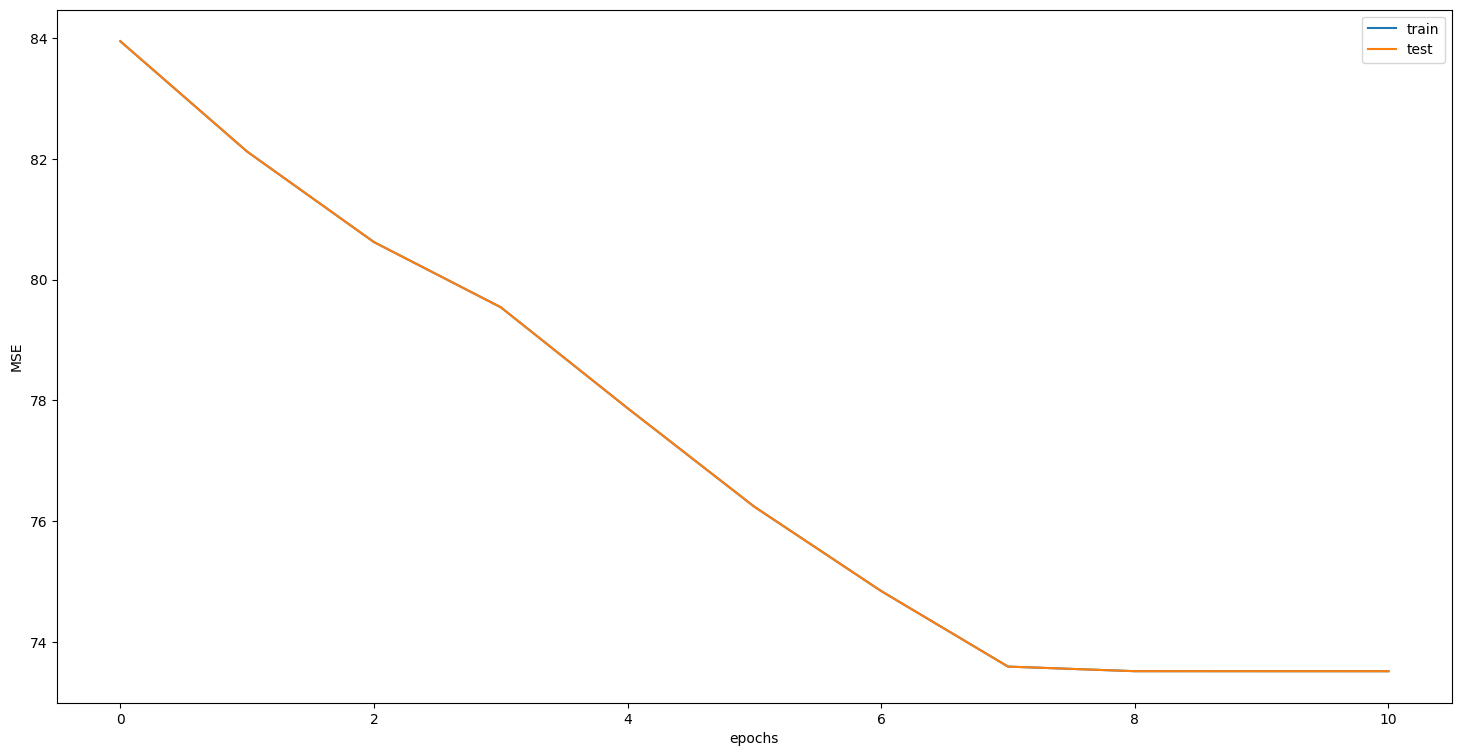

'\nplt.plot(Accuracy_train, label="train")\nplt.plot(Accuracy_test, label="test")\nplt.xlabel("epochs")\nplt.ylabel("accuracy")\nplt.legend()\nplt.show()\n'

In [22]:
import matplotlib.pyplot as plt
 
plt.plot(Loss_train[30:], label="train")
plt.plot(Loss_train[30:], label="test")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()
'''
plt.plot(Accuracy_train, label="train")
plt.plot(Accuracy_test, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()
'''

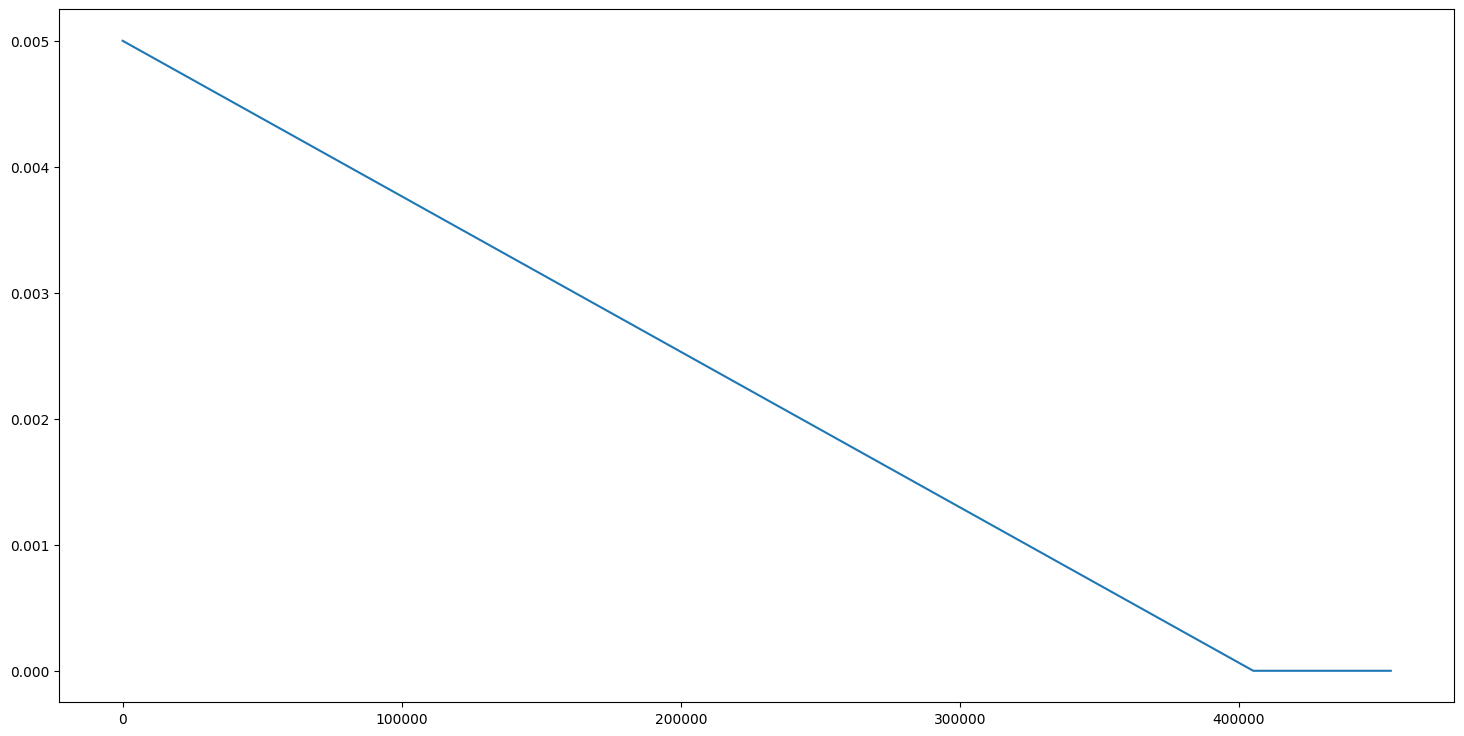

In [23]:
plt.plot(lrs)

In [24]:
scaler = StandardScaler()
scaler.fit(df_exam)
df_exam_norm = scaler.transform(df_exam)
df_exam = pd.DataFrame(df_exam_norm, columns=df_exam.columns, index=df_exam.index)


In [25]:
#df_exam
df_exam_exit = pd.DataFrame(0, columns=["year"], index=df_exam.index)
df_exam_exit
#df_exam_exit.loc[18991] = 5
#df_exam_exit


,year
id,
3416,0
18991,0
11105,0
18902,0
18958,0
...,...
15293,0
7469,0
6586,0


In [26]:
model.eval()

with torch.no_grad():
    for index, row in df_exam.iterrows():
        data = torch.tensor(row, dtype=torch.float)
        data = data.unsqueeze(0)
#        print(data)
        preds = model(data)
#        print(preds)
        #class_num = preds.argmax(1)
        df_exam_exit.loc[index] = preds.item()
        #print(class_num)

/tmp/ipykernel_30976/260871977.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row, dtype=torch.float)
/tmp/ipykernel_30976/260871977.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1999.68359375' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_exam_exit.loc[index] = preds.item()
/tmp/ipykernel_30976/260871977.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = torch.tensor(row, dtype=torch.float)


In [30]:
df_exam_exit.describe()
#df_exam_exit_2 = pd.DataFrame(0, columns=["year"], index=df_exam.index)
#df_exam_exit.loc[df_exam_exit['year'] > 2011, 'year'] = 2011
#df_exam_exit.loc[df_exam_exit['year'] < 1922, 'year'] = 1922
#df_exam_exit

,year
count,6000.000000
mean,1998.754463
std,5.157663
min,1962.335449
25%,1994.821045
50%,1999.299316
75%,2002.651978
max,2011.000000


In [146]:
#df_exam_exit = df_exam_exit.drop(["col"], axis=1)


In [31]:
df_exam_exit.to_csv("./ulala4.csv")

In [32]:
torch.save(model.state_dict(), "ulala4.pth")